# Carlos Cantu
# DSC 530
# Week 10 

##  lets pull in the data and import some functions 

In [7]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

Downloaded 1995FemRespData.dat.gz
Downloaded 2006_2010_FemRespSetup.dct
Downloaded 2006_2010_FemResp.dat.gz


In [2]:
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
import nsfg
import survival

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12121 sha256=57183abcd595774fc9485e0065f100a2ab8cc527360f5fadbcc54a261db4fc1b
  Stored in directory: c:\users\cantu\appdata\local\pip\cache\wheels\ba\30\d8\653166652404970cf48ec032ff1e90784bb804739d1834fc01
Successfully built empiricaldist


## Pages 180-181: 13-1 

## In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

## Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

## Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

## Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [8]:
# pull in the cycles required 
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [5]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [10]:
# Allows me to cycle 6 and 7 through my function ... I pulled in the cycles in the first cell 
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1] 

In [21]:
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="green", alpha=0.1) # should be a gradient of hues 

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [29]:
def ResampleDivorceCurveByDecade(resps):  # this will be my function call to plot
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel=" Marriage Years", ylabel=" undivorced rates", axis=[0, 28, 0, 1])

In [26]:
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))  # all groups 50s to 90s 
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [27]:
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

C:\Users\cantu\OneDrive - Bellevue University\Documents\Data Science Masters\Data exploration and analysis DSC530\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\cantu\OneDrive - Bellevue University\Documents\Data Science Masters\Data exploration and analysis DSC530\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\cantu\OneDrive - Bellevue University\Documents\Data Science Masters\Data exploration and analysis DSC530\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\cantu\OneDrive - Bellevue Un

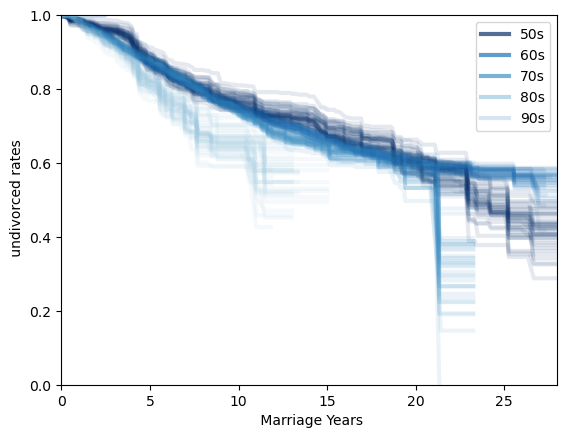

In [30]:
ResampleDivorceCurveByDecade([married6, married7]) # may be a tad mushed together 

As we can see the rates are  relatively similar and fall low between 20 to 25 years. I hypothesize that the survival analysis will be drastically different in the 2000s and on. 